In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import torch.utils.data

/home/sushlok/anaconda3/envs/fyp/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def read_dataset(data_root, mode):
    """
    Read dataset from data_root.
    """
    if mode == 'train':
        # list all sequence folders in train dir
        path = os.path.join(data_root, 'train')
        seq_list = os.listdir(path)
        
    elif mode == 'test':
        path = os.path.join(data_root, 'test')
        seq_list = os.listdir(path)
    else:
        raise ValueError('Invalid mode: {}'.format(mode))
    
    dataset = {}
    seq_lens = {}
    for seq in seq_list:
        seq_root = os.path.join(path, seq)
        img_list = os.listdir(seq_root)
        img_list = [os.path.join(seq_root, img) for img in img_list]
        img_list.sort()
        
        dataset[seq] = img_list
        seq_lens[seq] = len(img_list)
    
    return dataset, seq_lens
    
    
    

In [3]:
# test sample
dataset = read_dataset("/home/sushlok/fyp/dataset/GOPRO_Large_all(2)", 'train')


In [4]:
from torch.utils.data import Dataset
from PIL import Image

class Gopro(Dataset):
    def __init__(self, data_root, transform, seq_len = [5,20], speed_range=[1, 10],train=True, mode='train'):
        # Set arguments
        self.data_root = data_root
        self.max_seq_len = seq_len[-1]
        self.min_seq_len = seq_len[0]
        self.speed_range = speed_range
        self.train = train
        self.transform = transform
        assert mode in ['train', 'test'], 'Must be \'train\' or \'test\'.'
        self.mode = mode

        # Read dataset
        self.raw_data, self.seq_lens = read_dataset(self.data_root, self.mode)
        self.seq = list(self.raw_data.keys())
        self.total_imgs = 0
        for i in range(len(self.seq)):
            self.total_imgs += self.seq_lens[self.seq[i]] 
        # print(self.total_imgs)
            
    def __len__(self):
        return self.total_imgs*(self.max_seq_len - self.max_seq_len + 1)*(self.speed_range[-1] - self.speed_range[0] + 1)
        
    def __getitem__(self, idx):
        idx = idx%self.total_imgs
        # print(idx)
        seq_num = 0
        while(idx - self.seq_lens[self.seq[seq_num]] >= 0):
            idx = idx - self.seq_lens[self.seq[seq_num]]
            seq_num += 1
        seq = self.seq[seq_num]
        # print(seq)
        speed = np.random.randint(low = self.speed_range[0], high=self.speed_range[-1]+1)
        self.speed = speed
        
        self.seq_gen = np.random.randint(low = self.min_seq_len, high = self.max_seq_len+1)
        
        self.image_list = []
        
        if(idx + self.seq_gen*speed >= self.seq_lens[seq]):
            idx = self.seq_lens[seq] - self.seq_gen*speed - 1
            
        for i in range(self.seq_gen):
            # read image from path
            img_path = self.raw_data[seq][idx + i*speed]
            img = Image.open(img_path)
            
            self.image_list.append(self.transform(img))
            
        # create corresponding blurr image
        blurry_image = 0
        for i in range(self.seq_gen*speed):
            img_path = self.raw_data[seq][idx + i]
            blurry_image = blurry_image + np.asarray(Image.open(img_path))/(self.seq_gen*speed)
        # blurry_image = blurry_image
        self.blurry_image = Image.fromarray(np.uint8(blurry_image))
        
        # Pack data
        data = {
            'speed': torch.tensor(self.speed),
            'length': torch.tensor(self.seq_gen),
            'blur': self.transform(self.blurry_image),
            'gen_seq': self.image_list
        }

        return data


In [5]:
torch.backends.cudnn.benchmark  = True

In [6]:
# define training data transform

transform =  transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        
    ]
)


In [16]:
trainset = Gopro("/home/sushlok/fyp/dataset/GOPRO_Large_all(2)", transform, seq_len = [4,10], speed_range=[1, 2],train=True, mode='train')
testset = Gopro("/home/sushlok/fyp/dataset/GOPRO_Large_all(2)", transform, seq_len = [4,10], speed_range=[1, 2],train=False, mode='test')

In [17]:
print(len(trainset))

2100


In [18]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

In [25]:
dataiter = iter(trainloader)
data = dataiter.next()
images = data['gen_seq']
blurry_image = data['blur']
speed = data['speed']
length = data['length'] 




0
{'speed': tensor([3, 3, 2, 3]), 'length': tensor([ 7, 10,  6,  6]), 'blur': tensor([[[[ 0.9294,  0.9059,  0.9059,  ...,  0.0510,  0.0196, -0.0196],
          [ 0.9294,  0.9216,  0.9137,  ...,  0.0431,  0.0196, -0.0039],
          [ 0.9373,  0.9373,  0.9294,  ...,  0.0431,  0.0196, -0.0039],
          ...,
          [-0.2078, -0.1765, -0.1294,  ..., -0.0118, -0.0118, -0.0118],
          [-0.2000, -0.1686, -0.1294,  ..., -0.0118, -0.0118, -0.0118],
          [-0.2078, -0.1843, -0.1451,  ..., -0.0118, -0.0118, -0.0118]],

         [[ 0.8431,  0.8196,  0.8275,  ...,  0.0196, -0.0039, -0.0353],
          [ 0.8118,  0.8118,  0.8118,  ...,  0.0196, -0.0039, -0.0275],
          [ 0.8039,  0.8118,  0.8196,  ...,  0.0118, -0.0118, -0.0275],
          ...,
          [-0.1922, -0.1608, -0.1216,  ...,  0.0745,  0.0745,  0.0667],
          [-0.1843, -0.1608, -0.1216,  ...,  0.0745,  0.0745,  0.0745],
          [-0.1922, -0.1686, -0.1373,  ...,  0.0745,  0.0745,  0.0745]],

         [[ 0.6471,  0.6

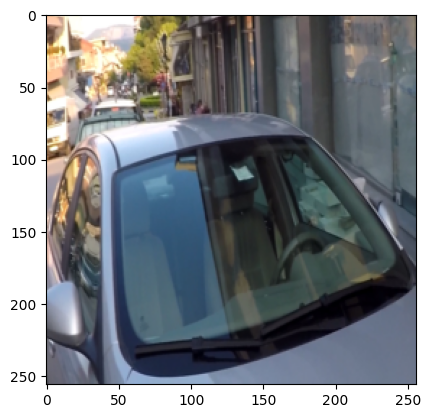

In [21]:
plt.imshow(images[0][0].permute(1,2,0)*0.5 + 0.5)
plt.show()

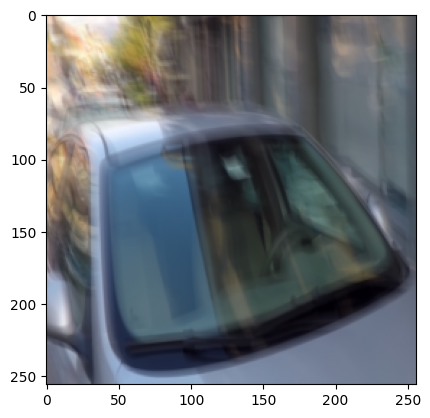

In [22]:
plt.imshow(blurry_image[0].permute(1,2,0)*0.5 + 0.5)
plt.show()

In [23]:
print(speed)

tensor([3, 3, 2, 3])


In [24]:
print(length)

tensor([ 7, 10,  6,  6])


# modules we have to write:
1. blurred image at t to t
2. motion encoding from blurred image (Ht)
3. modeling encoder:
    input: img(t+T/2), motion encoding(t), time stamp(k)
    output: latent representation p(z(t))
4. decoder: latent to image decoder
5. discriminator